# Predicting Destination - AirBnB Customers

The goal for this analysis is to build a neural network, using Tensorflow, that can predict which country a new user of AirBnB will make his/her first trip to. More information about the data can be found at: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings. This data was originally from a 2016 Kaggle competition, sponsored by AirBnB. I believe that it is still an excellent learning reasource because of the opportunity to clean data, engineering features, and build a model, which will all significantly impact the quality of the predictions.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from scipy import stats
pd.set_option("display.max_columns", 1000)
import math
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.cross_validation import train_test_split
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import classification_report

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
# Load the data
countries = pd.read_csv("countries.csv")
test = pd.read_csv("test_users.csv")
train = pd.read_csv("train_users_2.csv")
sessions = pd.read_csv("sessions.csv")

First, let's have a look at the data we are working with.

In [ ]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [ ]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
sessions.head(10)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [ ]:
print(test.shape)
print(train.shape)
print(sessions.shape)

(62096, 15)
(213451, 16)
(10567737, 6)


Our target feature is 'country_destination,' which can be found in the 'train' dataframe. Given this, let's first explore the sessions data, then merge it with the train dataframe (on 'user_id'), after we are done transforming it.

## Sessions

In [ ]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [ ]:
#Drop rows where user_id is null because we want to tie everything back to a user.
sessions = sessions[sessions.user_id.notnull()]

In [ ]:
sessions.isnull().sum()

user_id                0
action             79480
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed      135483
dtype: int64

In [ ]:
# How do nulls in action relate to action_type
sessions[sessions.action.isnull()].action_type.value_counts()

message_post    79480
Name: action_type, dtype: int64

In [ ]:
# Every action with a null value, has action_type equal to 'message_post'.
# Let's change all the null values to 'message'
sessions.loc[sessions.action.isnull(), 'action'] = 'message'

In [ ]:
sessions.isnull().sum()

user_id                0
action                 0
action_type      1122957
action_detail    1122957
device_type            0
secs_elapsed      135483
dtype: int64

In [ ]:
# action_type and action_detail are missing values in the same rows, this simplifies things a little.
print(sessions[sessions.action_type.isnull()].action.value_counts())
print()
print(sessions[sessions.action_detail.isnull()].action.value_counts())

show                      580485
similar_listings_v2       168457
lookup                    161422
campaigns                 104331
track_page_view            80949
index                      16682
localization_settings       5380
uptodate                    3329
signed_out_modal            1054
currencies                   292
update                       225
braintree_client_token       120
check                        119
widget                        75
phone_verification            16
satisfy                        9
disaster_action                6
track_activity                 6
Name: action, dtype: int64

show                      580485
similar_listings_v2       168457
lookup                    161422
campaigns                 104331
track_page_view            80949
index                      16682
localization_settings       5380
uptodate                    3329
signed_out_modal            1054
currencies                   292
update                       225
braintree_clien

To fill in the null values for action_type and action_detail, we will perform these steps:

1. Use the most common value relative to each user and action
2. Use the most common value relative to each action
3. Use the value 'missing'

In [ ]:
# function that finds the most common value of a feature, specific to each user and action.
def most_common_value_by_user(merge_df, feature): 
    # Find the value counts for a feature, for each user and action.
    new_df = pd.DataFrame(merge_df.groupby(['user_id','action'])[feature].value_counts())
    # Set the index to a new feature so that it can be transformed.
    new_df['index_tuple'] = new_df.index 
    # Change the feature name to count, since it is the value count of the feature.
    new_df['count'] = new_df[feature]
    
    new_columns = ['user_id','action',feature]
    # separate the features of index_tuple (a list), into their own columns
    for n,col in enumerate(new_columns):
        new_df[col] = new_df.index_tuple.apply(lambda index_tuple: index_tuple[n])
    
    # reset index and drop index_tuple
    new_df = new_df.reset_index(drop = True)
    new_df = new_df.drop(['index_tuple'], axis = 1) 
    
    # Create a new dataframe for each user, action, and the count of the most common feature
    new_df_max = pd.DataFrame(new_df.groupby(['user_id','action'], as_index = False)['count'].max())
    # Merge dataframes to include the name of the most common feature
    new_df_max = new_df_max.merge(new_df, on = ['user_id','action','count'])
    # Drop count as it is not needed for the next step
    new_df_max = new_df_max.drop('count', axis = 1)
    
    # Merge with main dataframe (sessions)
    merge_df = merge_df.merge(new_df_max, left_on = ['user_id','action'], right_on = ['user_id','action'], how = 'left')
    
    return merge_df

In [ ]:
sessions = most_common_value_by_user(sessions, 'action_type')
print("action_type is complete.")

sessions = most_common_value_by_user(sessions, 'action_detail')
print("action_detail is complete.")

action_type is complete.
action_detail is complete.


In [ ]:
# Replace the nulls with the values from the features created by 'most_common_value_by_user' function.
sessions.loc[sessions.action_type_x.isnull(), 'action_type_x'] = sessions.action_type_y
sessions.loc[sessions.action_detail_x.isnull(), 'action_detail_x'] = sessions.action_detail_y

# Change the features' names to their originals and drop unnecessary features.
sessions['action_type'] = sessions.action_type_x
sessions['action_detail'] = sessions.action_detail_x
sessions = sessions.drop(['action_type_x','action_type_y','action_detail_x','action_detail_y'], axis = 1)

That helped to remove some of the nulls values. Now let's try the more general function.

In [ ]:
sessions.isnull().sum()

user_id               0
action                0
device_type           0
secs_elapsed     167233
action_type      531386
action_detail    531386
dtype: int64

In [ ]:
# function that finds the most common value of a feature, specific to each action.
def most_common_value_by_all_users(merge_df, feature):
    # Group by action, then find the value counts of the feature
    new_df = pd.DataFrame(merge_df.groupby('action')[feature].value_counts())
    # Set the index to a new feature so that it can be transformed.
    new_df['index_tuple'] = new_df.index 
    # Change the feature name to count, since it is the value count of the feature.
    new_df['count'] = new_df[feature]
    
    new_columns = ['action',feature]
    # separate the features of index_tuple (a list), into their own columns
    for n,col in enumerate(new_columns):
        new_df[col] = new_df.index_tuple.apply(lambda index_tuple: index_tuple[n])
    
    # reset index and drop index_tuple
    new_df = new_df.reset_index(drop = True)
    new_df = new_df.drop(['index_tuple'], axis = 1) 
    
    # Create a new dataframe for each action, and the count of the most common feature
    new_df_max = pd.DataFrame(new_df.groupby('action', as_index = False)['count'].max())
    # Merge dataframes to include the name of the most common feature
    new_df_max = new_df_max.merge(new_df, on = ['action','count'])
    # Drop count as it is not needed for next step
    new_df_max = new_df_max.drop('count', axis = 1)
    
    # Merge dataframe with main dataframe (sessions)
    merge_df = merge_df.merge(new_df_max, left_on = 'action', right_on = 'action', how = 'left')
    
    return merge_df

In [ ]:
sessions = most_common_value_by_all_users(sessions, 'action_type')
print("action_type is complete.")
sessions = most_common_value_by_all_users(sessions, 'action_detail')
print("action_detail is complete.")

action_type is complete.
action_detail is complete.


In [ ]:
# Replace the nulls with the values from the features created by 'most_common_value_by_all_users' function.
sessions.loc[sessions.action_type_x.isnull(), 'action_type_x'] = sessions.action_type_y
sessions.loc[sessions.action_detail_x.isnull(), 'action_detail_x'] = sessions.action_detail_y

# Change the features' names to their originals and drop the unnecessary features.
sessions['action_type'] = sessions.action_type_x
sessions['action_detail'] = sessions.action_detail_x
sessions = sessions.drop(['action_type_x','action_type_y','action_detail_x','action_detail_y'], axis = 1)

There are still some null values remaining. Let's take a look at what actions these null values are related to.

In [ ]:
sessions.isnull().sum()

user_id               0
action                0
device_type           0
secs_elapsed     167233
action_type      415562
action_detail    415562
dtype: int64

In [ ]:
sessions[sessions.action_type.isnull()].action.value_counts()

similar_listings_v2       168457
lookup                    161422
track_page_view            80949
uptodate                    3329
signed_out_modal            1054
braintree_client_token       120
check                        119
widget                        75
phone_verification            16
satisfy                        9
disaster_action                6
track_activity                 6
Name: action, dtype: int64

Let's take a look at the value counts for all of the actions to see how their frequency compares to others.

In [ ]:
sessions.action.value_counts()

show                           2866444
index                           893606
search_results                  723124
personalize                     704782
search                          533887
ajax_refresh_subtotal           486414
update                          370379
similar_listings                363423
social_connections              337764
reviews                         324825
create                          225961
active                          187370
similar_listings_v2             168457
lookup                          161422
dashboard                       152515
header_userpic                  141315
collections                     124067
edit                            108999
campaigns                       104647
track_page_view                  80949
message                          79484
unavailabilities                 77985
qt2                              64585
notifications                    61946
confirm_email                    58565
requested                

'similar_listings_v2', 'lookup', and 'track_page_view' are the three main features with null values. I will give each of them specific values for action_type and action_detail, otherwise I will set the value to 'missing'.

In [ ]:
# Use these values for 'similar_listings_v2' since they are similar actions.
print(sessions[sessions.action == 'similar_listings'].action_type.value_counts())
print(sessions[sessions.action == 'similar_listings'].action_detail.value_counts())

data    363423
Name: action_type, dtype: int64
similar_listings    363423
Name: action_detail, dtype: int64


In [ ]:
sessions.loc[sessions.action == 'similar_listings_v2', 'action_type'] = "data"
sessions.loc[sessions.action == 'similar_listings_v2', 'action_detail'] = "similar_listings"

# No other action is similar, so we'll use the same work for all three features.
sessions.loc[sessions.action == 'lookup', 'action_type'] = "lookup"
sessions.loc[sessions.action == 'lookup', 'action_detail'] = "lookup"

sessions.loc[sessions.action == 'track_page_view', 'action_type'] = "track_page_view"
sessions.loc[sessions.action == 'track_page_view', 'action_detail'] = "track_page_view"

sessions.action_type = sessions.action_type.fillna("missing")
sessions.action_detail = sessions.action_detail.fillna("missing")

All good. Now just secs_elapsed is left.

In [ ]:
sessions.isnull().sum()

user_id               0
action                0
device_type           0
secs_elapsed     167233
action_type           0
action_detail         0
dtype: int64

To keep things simple, let's fill the nulls with the median value for each action.

In [ ]:
# Find the median secs_elapsed for each action
median_duration = pd.DataFrame(sessions.groupby('action', as_index = False)['secs_elapsed'].median())
median_duration.head()

,action,secs_elapsed
0,10,47320.5
1,11,72764.0
2,12,180407.0
3,15,54223.0
4,about_us,18627.5


In [ ]:
# Merge dataframes on action
sessions = sessions.merge(median_duration, left_on = 'action', right_on = 'action', how = 'left')
print("Merge complete.")
# if secs_elapsed is null, fill it with the median value
sessions.loc[sessions.secs_elapsed_x.isnull(), 'secs_elapsed_x'] = sessions.secs_elapsed_y
print("Nulls are filled.")
# Change column name
sessions['secs_elapsed'] = sessions.secs_elapsed_x
print("Column is created.")
# Drop unneeded columns
sessions = sessions.drop(['secs_elapsed_x','secs_elapsed_y'], axis = 1)
print("Columns are dropped.")

Merge complete.
Nulls are filled.
Column is created.
Columns are dropped.


All clean!

In [ ]:
sessions.isnull().sum()

user_id          0
action           0
device_type      0
action_type      0
action_detail    0
secs_elapsed     0
dtype: int64

I think the best next step would be to take the information from sessions and summarize it. We will create a new dataframe, add the most important features, then join it with the train dataframe.

## Sessions' Summary

In [ ]:
sessions.head()

,user_id,action,device_type,action_type,action_detail,secs_elapsed
0,d1mm9tcy42,lookup,Windows Desktop,lookup,lookup,319.0
1,d1mm9tcy42,search_results,Windows Desktop,click,view_search_results,67753.0
2,d1mm9tcy42,lookup,Windows Desktop,lookup,lookup,301.0
3,d1mm9tcy42,search_results,Windows Desktop,click,view_search_results,22141.0
4,d1mm9tcy42,lookup,Windows Desktop,lookup,lookup,435.0


In [ ]:
# sessions_summary is set to the number of times a user_id appears in sessions
sessions_summary = pd.DataFrame(sessions.user_id.value_counts(sort = False))
# Set action_count equal to user_id
sessions_summary['action_count'] = sessions_summary.user_id
# Set user_id equal to the index
sessions_summary['user_id'] = sessions_summary.index
# Rest the index
sessions_summary = sessions_summary.reset_index(drop = True)

Looks good, now let's add some features!

In [ ]:
sessions_summary.head()

,user_id,action_count
0,lvs98g7ggz,12
1,9hue70lsfi,22
2,8wqf53khcc,468
3,q7jew74rm9,50
4,f2t2nbphmv,43


In [ ]:
# user_duration is the sums of secs_elapsed for each user
user_duration = pd.DataFrame(sessions.groupby('user_id').secs_elapsed.sum())
user_duration['user_id'] = user_duration.index
# Merge dataframes
sessions_summary = sessions_summary.merge(user_duration)
# Create new feature, 'duration', to equal secs_elapsed
sessions_summary['duration'] = sessions_summary.secs_elapsed
sessions_summary = sessions_summary.drop("secs_elapsed", axis = 1)

In [ ]:
sessions_summary.head()

,user_id,action_count,duration
0,lvs98g7ggz,12,113525.5
1,9hue70lsfi,22,439490.0
2,8wqf53khcc,468,7468072.0
3,q7jew74rm9,50,363874.0
4,f2t2nbphmv,43,3340242.0


In [ ]:
# This function finds the most common value, for a specific feature, for each user.
def most_frequent_value(merge_df, feature):
    # Group by the users and find the value counts of the feature
    new_df = pd.DataFrame(sessions.groupby('user_id')[feature].value_counts())
    # The index is a tuple, and we need to seperate it, so let's create a new feature from it.
    new_df['index_tuple'] = new_df.index
    # The new columns are the features created from the tuple.
    new_columns = ['user_id',feature]
    for n,col in enumerate(new_columns):
        new_df[col] = new_df.index_tuple.apply(lambda index_tuple: index_tuple[n])
    
    # Drop the old index (the tuple index)
    new_df = new_df.reset_index(drop = True)
    # Drop the unneeded feature
    new_df = new_df.drop('index_tuple', axis = 1)
    # Select the first value for each user, its most common
    new_df = new_df.groupby('user_id').first()
    
    # Set user_id equal to the index, then reset the index
    new_df['user_id'] = new_df.index
    new_df = new_df.reset_index(drop = True)
    
    merge_df = merge_df.merge(new_df)
    
    return merge_df

In [ ]:
# For each categorical feature in sessions, find the most common value for each user.
sessions_feature = ['action','action_type','action_detail','device_type']

for feature in sessions_feature:
    sessions_summary = most_frequent_value(sessions_summary, feature)
    print("{} is complete.".format(feature))

action is complete.
action_type is complete.
action_detail is complete.
device_type is complete.


In [ ]:
sessions_summary.head()

,user_id,action_count,duration,action,action_type,action_detail,device_type
0,lvs98g7ggz,12,113525.5,search_results,click,view_search_results,Windows Desktop
1,9hue70lsfi,22,439490.0,show,view,-unknown-,-unknown-
2,8wqf53khcc,468,7468072.0,show,view,p3,Mac Desktop
3,q7jew74rm9,50,363874.0,show,view,user_profile,iPhone
4,f2t2nbphmv,43,3340242.0,update,submit,update_listing,Windows Desktop


In [ ]:
# This function finds the number of unique values of a feature for each user.
def unique_features(feature, feature_name, merge_df):
    # Create a dataframe by grouping the users and the feature
    unique_feature = pd.DataFrame(sessions.groupby('user_id')[feature].unique())
    unique_feature['user_id'] = unique_feature.index
    unique_feature = unique_feature.reset_index(drop = True)
    # Create a new feature equal to the number of unique features for each user
    unique_feature[feature_name] = unique_feature[feature].map(lambda x: len(x))
    # Drop the needed feature
    unique_feature = unique_feature.drop(feature, axis = 1)
    merge_df = merge_df.merge(unique_feature, on = 'user_id')
    return merge_df

In [ ]:
# Apply unique_features to each of the categorical features in sessions
sessions_summary = unique_features('action', 'unique_actions', sessions_summary)
print("action is complete.")
sessions_summary = unique_features('action_type', 'unique_action_types', sessions_summary)
print("action_type is complete.")
sessions_summary = unique_features('action_detail', 'unique_action_details', sessions_summary)
print("action_detail is complete.")
sessions_summary = unique_features('device_type', 'unique_device_types', sessions_summary)
print("device_type is complete.")

action is complete.
action_type is complete.
action_detail is complete.
device_type is complete.


In [ ]:
sessions_summary.head()

,user_id,action_count,duration,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types
0,lvs98g7ggz,12,113525.5,search_results,click,view_search_results,Windows Desktop,3,3,3,1
1,9hue70lsfi,22,439490.0,show,view,-unknown-,-unknown-,7,5,8,2
2,8wqf53khcc,468,7468072.0,show,view,p3,Mac Desktop,41,7,22,3
3,q7jew74rm9,50,363874.0,show,view,user_profile,iPhone,8,5,8,2
4,f2t2nbphmv,43,3340242.0,update,submit,update_listing,Windows Desktop,14,5,16,1


In [ ]:
# Find the maximum and minimum secs_elapsed/duration for each user in sessions.
max_durations = pd.DataFrame(sessions.groupby(['user_id'], as_index = False)['secs_elapsed'].max())
sessions_summary = sessions_summary.merge(max_durations, on = 'user_id')
sessions_summary['max_duration'] = sessions_summary.secs_elapsed
sessions_summary = sessions_summary.drop('secs_elapsed', axis = 1)

print("max_durations is complete.")

min_durations = pd.DataFrame(sessions.groupby(['user_id'], as_index = False)['secs_elapsed'].min())
sessions_summary = sessions_summary.merge(min_durations, on = 'user_id')
sessions_summary['min_duration'] = sessions_summary.secs_elapsed
sessions_summary = sessions_summary.drop('secs_elapsed', axis = 1)

print("min_durations is complete.")

max_durations is complete.
min_durations is complete.


In [ ]:
# Find the average duration for each user
sessions_summary['avg_duration'] = sessions_summary.duration / sessions_summary.action_count

In [ ]:
sessions_summary.head(5)

,user_id,action_count,duration,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types,max_duration,min_duration,avg_duration
0,lvs98g7ggz,12,113525.5,search_results,click,view_search_results,Windows Desktop,3,3,3,1,31091.0,117.0,9460.458333
1,9hue70lsfi,22,439490.0,show,view,-unknown-,-unknown-,7,5,8,2,244093.0,286.0,19976.818182
2,8wqf53khcc,468,7468072.0,show,view,p3,Mac Desktop,41,7,22,3,814514.0,0.0,15957.418803
3,q7jew74rm9,50,363874.0,show,view,user_profile,iPhone,8,5,8,2,64106.0,12.0,7277.480000
4,f2t2nbphmv,43,3340242.0,update,submit,update_listing,Windows Desktop,14,5,16,1,1107772.0,68.0,77680.046512


In [ ]:
# Add new features based on the type of device that the user used most frequently.
apple_device = ['Mac Desktop','iPhone','iPdad Tablet','iPodtouch']
desktop_device = ['Mac Desktop','Windows Desktop','Chromebook','Linux Desktop']
tablet_device = ['Android App Unknown Phone/Tablet','iPad Tablet','Tablet']
mobile_device = ['Android Phone','iPhone','Windows Phone','Blackberry','Opera Phone']

device_types = {'apple_device': apple_device, 
                'desktop_device': desktop_device,
                'tablet_device': tablet_device,
                'mobile_device': mobile_device}

for device in device_types:
    sessions_summary[device] = 0
    sessions_summary.loc[sessions_summary.device_type.isin(device_types[device]), device] = 1

In [ ]:
sessions_summary.head()

,user_id,action_count,duration,action,action_type,action_detail,device_type,unique_actions,unique_action_types,unique_action_details,unique_device_types,max_duration,min_duration,avg_duration,tablet_device,mobile_device,desktop_device,apple_device
0,lvs98g7ggz,12,113525.5,search_results,click,view_search_results,Windows Desktop,3,3,3,1,31091.0,117.0,9460.458333,0,0,1,0
1,9hue70lsfi,22,439490.0,show,view,-unknown-,-unknown-,7,5,8,2,244093.0,286.0,19976.818182,0,0,0,0
2,8wqf53khcc,468,7468072.0,show,view,p3,Mac Desktop,41,7,22,3,814514.0,0.0,15957.418803,0,0,1,1
3,q7jew74rm9,50,363874.0,show,view,user_profile,iPhone,8,5,8,2,64106.0,12.0,7277.480000,0,1,0,1
4,f2t2nbphmv,43,3340242.0,update,submit,update_listing,Windows Desktop,14,5,16,1,1107772.0,68.0,77680.046512,0,0,1,0


In [ ]:
# Check if there are any null values before merging with train.
sessions_summary.isnull().sum()

user_id                  0
action_count             0
duration                 0
action                   0
action_type              0
action_detail            0
device_type              0
unique_actions           0
unique_action_types      0
unique_action_details    0
unique_device_types      0
max_duration             0
min_duration             0
avg_duration             0
tablet_device            0
mobile_device            0
desktop_device           0
apple_device             0
dtype: int64

In [ ]:
print(sessions_summary.shape)
print(train.shape)
print(test.shape)

(135483, 18)
(213451, 16)
(62096, 15)


In [ ]:
# Merge train and test with sessions_summary
train1 = train.merge(sessions_summary, left_on = train['id'], right_on = sessions_summary['user_id'], how = 'inner')
# train2 is equal to the users that are not in train1
train2 = train[~train.id.isin(train1.id)]
train = pd.concat([train1, train2])

test1 = test.merge(sessions_summary, left_on = test['id'], right_on = sessions_summary['user_id'], how = 'inner')
# test2 is equal to the users that are not in test1
test2 = test[~test.id.isin(test1.id)]
test = pd.concat([test1, test2])

The next step is to transform the features so that they are ready for training the neural network.

## Feature Engineering

In [ ]:
# Concatenate train and test because all transformations need to happen to both dataframes.
df = pd.concat([train,test])

In [ ]:
df.head()

,action,action_count,action_detail,action_type,affiliate_channel,affiliate_provider,age,apple_device,avg_duration,country_destination,date_account_created,date_first_booking,desktop_device,device_type,duration,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,max_duration,min_duration,mobile_device,signup_app,signup_flow,signup_method,tablet_device,timestamp_first_active,unique_action_details,unique_action_types,unique_actions,unique_device_types,user_id
0,show,127.0,p3,view,sem-non-brand,google,62.0,0.0,27283.503937,other,2014-01-01,2014-01-04,1.0,Windows Desktop,3465005.0,omg,Chrome,Windows Desktop,MALE,d1mm9tcy42,en,606881.0,2.0,0.0,Web,0,basic,0.0,20140101000936,10.0,7.0,17.0,2.0,d1mm9tcy42
1,show,12.0,p3,view,direct,direct,NaN,1.0,24522.125000,NDF,2014-01-01,NaN,1.0,Mac Desktop,294265.5,untracked,Firefox,Mac Desktop,-unknown-,yo8nz8bqcq,en,115983.0,36.0,0.0,Web,0,basic,0.0,20140101001558,8.0,4.0,7.0,1.0,yo8nz8bqcq
2,create,16.0,-unknown-,-unknown-,sem-brand,google,NaN,0.0,71887.156250,NDF,2014-01-01,NaN,1.0,Windows Desktop,1150194.5,omg,Firefox,Windows Desktop,-unknown-,4grx6yxeby,en,336801.0,53.0,0.0,Web,0,basic,0.0,20140101001639,8.0,6.0,13.0,2.0,4grx6yxeby
3,ajax_refresh_subtotal,160.0,view_search_results,click,direct,direct,NaN,0.0,24384.262500,NDF,2014-01-01,NaN,1.0,Windows Desktop,3901482.0,linked,Chrome,Windows Desktop,-unknown-,ncf87guaf0,en,732296.0,0.0,0.0,Web,0,basic,0.0,20140101002146,13.0,7.0,19.0,3.0,ncf87guaf0
4,index,8.0,-unknown-,-unknown-,direct,direct,NaN,1.0,2163.187500,GB,2014-01-01,2014-01-02,0.0,iPhone,17305.5,untracked,-unknown-,iPhone,-unknown-,4rvqpxoh3h,en,14750.5,21.0,1.0,iOS,25,basic,0.0,20140101002619,1.0,1.0,7.0,1.0,4rvqpxoh3h


In [ ]:
df.shape

(275547, 34)

In [ ]:
df.isnull().sum()

action                     140064
action_count               140064
action_detail              140064
action_type                140064
affiliate_channel               0
affiliate_provider              0
age                        116866
apple_device               140064
avg_duration               140064
country_destination         62096
date_account_created            0
date_first_booking         186639
desktop_device             140064
device_type                140064
duration                   140064
first_affiliate_tracked      6085
first_browser                   0
first_device_type               0
gender                          0
id                              0
language                        0
max_duration               140064
min_duration               140064
mobile_device              140064
signup_app                      0
signup_flow                     0
signup_method                   0
tablet_device              140064
timestamp_first_active          0
unique_action_

In [ ]:
# We don't need this because we already have id and it has 0 null values.
df = df.drop('user_id', axis = 1)

Since there are many users that do not appear in the sessions dataframe, all of their values are NaN. Let's sort out those nulls values first.

In [ ]:
def missing_session_data_cat(feature):
    return df[feature].fillna("missing")

def missing_session_data_cont(feature):
    return df[feature].fillna(0)

In [ ]:
session_features_cat = ['action','action_detail','action_type','device_type']
session_features_cont = ['action_count','apple_device','desktop_device','mobile_device','tablet_device',
                         'duration','avg_duration','max_duration','min_duration','unique_action_details',
                         'unique_action_types','unique_actions','unique_device_types']

for feature in session_features_cat:
    df[feature] = missing_session_data_cat(feature)
    
for feature in session_features_cont:
    df[feature] = missing_session_data_cont(feature)

That removed most of the null values!

In [ ]:
df.isnull().sum()

action                          0
action_count                    0
action_detail                   0
action_type                     0
affiliate_channel               0
affiliate_provider              0
age                        116866
apple_device                    0
avg_duration                    0
country_destination         62096
date_account_created            0
date_first_booking         186639
desktop_device                  0
device_type                     0
duration                        0
first_affiliate_tracked      6085
first_browser                   0
first_device_type               0
gender                          0
id                              0
language                        0
max_duration                    0
min_duration                    0
mobile_device                   0
signup_app                      0
signup_flow                     0
signup_method                   0
tablet_device                   0
timestamp_first_active          0
unique_action_

In [ ]:
df.action_count.describe()

count    275547.000000
mean         39.140927
std          88.944077
min           0.000000
25%           0.000000
50%           0.000000
75%          42.000000
max        2724.000000
Name: action_count, dtype: float64

In [ ]:
df[df.action_count > 0].action_count.describe()

count    135483.000000
mean         79.605301
std         113.439177
min           1.000000
25%          17.000000
50%          43.000000
75%          97.000000
max        2724.000000
Name: action_count, dtype: float64

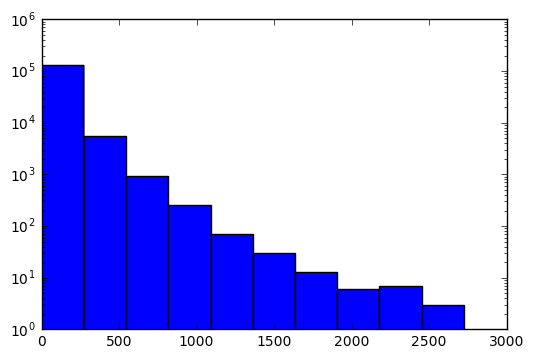

In [ ]:
plt.hist(df[df.action_count > 0].action_count)
plt.yscale('log')
plt.show()

In [ ]:
# Group action_count into quartiles.
df['action_count_quartile'] = df.action_count.map(lambda x: 0 if x == 0 else (
                                                            1 if x <= 17 else (
                                                            2 if x <= 43 else (
                                                            3 if x <= 97 else 4))))

In [ ]:
df[df.age.notnull()].age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

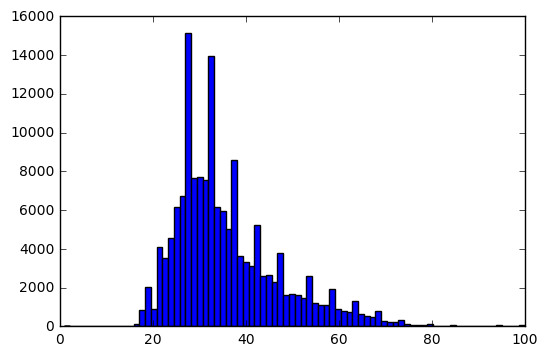

In [ ]:
plt.hist(df[df.age <= 100].age, bins = 80)
plt.show()

No one is 2014 years old. If anyone is older than 80, let's bring their age down to 80...I'm sure some of them wouldn't mind that.

In [ ]:
df.loc[df.age > 80, 'age'] = 80

In [ ]:
df[df.age.notnull()].age.describe()

count    158681.000000
mean         36.756436
std          12.770211
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max          80.000000
Name: age, dtype: float64

Let's see if there is a feature that is correlated with age, to help find good values for the nulls

In [ ]:
for feature in df.columns:
    if(df[feature].dtype == float or df[feature].dtype == int):
        correlation = stats.pearsonr(df[df.age.notnull()].age, df[df.age.notnull()][feature])
        print("Correlation with {} = {}".format(feature, correlation)) 

Correlation with action_count = (-0.064026876831618271, 8.935019331436594e-144)
Correlation with age = (1.0, 0.0)
Correlation with apple_device = (-0.11877768421316583, 0.0)
Correlation with avg_duration = (-0.015890959356089224, 2.4440110140227963e-10)
Correlation with desktop_device = (-0.04078523014721834, 2.1151097257467199e-59)
Correlation with duration = (-0.031522514371148634, 3.5056510866694804e-36)
Correlation with max_duration = (-0.046902158494160351, 5.5907076372683492e-78)
Correlation with min_duration = (-0.0061751882510133168, 0.013898465412299924)
Correlation with mobile_device = (-0.10935875994089284, 0.0)
Correlation with signup_flow = (-0.10945378061441423, 0.0)
Correlation with tablet_device = (0.032457538742075048, 2.94315571171229e-38)
Correlation with timestamp_first_active = (-0.10000080826874851, 0.0)
Correlation with unique_action_details = (-0.080635864696282103, 4.1759774725532945e-227)
Correlation with unique_action_types = (-0.087255839917087102, 1.0418634

Unfortunately, nothing is really correlated with age. Since there are too many missing values for age, I'm going to set the missing values equal to the median, 33.

In [ ]:
# Create age_group before filling in the nulls, so that the distribution is not altered.
df['age_group'] = df.age.map(lambda x: 0 if math.isnan(x) else (
                                       1 if x < 18 else (
                                       2 if x <= 33 else (
                                       3 if x <= 42 else 4))))

In [ ]:
df.age = df.age.fillna(33)

In [ ]:
df.age.isnull().sum()

0

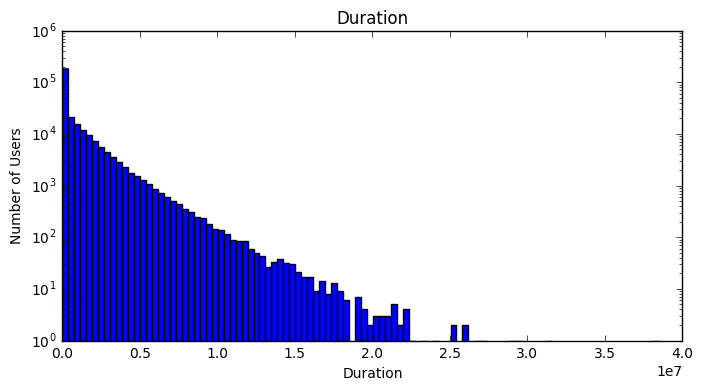

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df.duration, bins = 100)
plt.title("Duration")
plt.xlabel("Duration")
plt.ylabel("Number of Users")
plt.yscale('log')
plt.show()

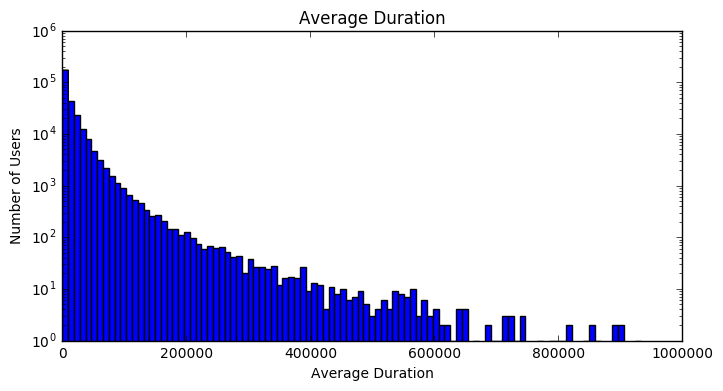

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(df.avg_duration, bins = 100)
plt.title("Average Duration")
plt.xlabel("Average Duration")
plt.ylabel("Number of Users")
plt.yscale('log')
plt.show()

In [ ]:
print(df.duration.describe())
print()
print(df.avg_duration.describe())

count    2.755470e+05
mean     7.671002e+05
std      1.570985e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.771662e+05
max      3.851321e+07
Name: duration, dtype: float64

count    275547.000000
mean      13423.996460
std       29962.460601
min           0.000000
25%           0.000000
50%           0.000000
75%       16553.788947
max      933452.333333
Name: avg_duration, dtype: float64


In [ ]:
print(np.percentile(df.duration, 50))
print(np.percentile(df.duration, 51))
print(np.percentile(df.duration, 75))
print()
print(np.percentile(df.avg_duration, 50))
print(np.percentile(df.avg_duration, 51))
print(np.percentile(df.avg_duration, 75))

0.0
678.46
877166.25

0.0
346.23
16553.7889474


In [ ]:
# Divide users into 3 equal-ish groups
df['duration_group'] = df.duration.map(lambda x: 0 if x == 0 else (
                                                 1 if x <= 877166.25 else 2))

df['avg_duration_group'] = df.avg_duration.map(lambda x: 0 if x == 0 else (
                                                         1 if x <= 16553.7889474 else 2))

In [ ]:
print(df.duration_group.value_counts())
print()
print(df.avg_duration_group.value_counts())

0    140064
2     68887
1     66596
Name: duration_group, dtype: int64

0    140064
2     68887
1     66596
Name: avg_duration_group, dtype: int64


There are too many unknowns to try to group them with a gender. I'm going to leave OTHER because it could/probably represent(s) people who do not identify as either male/female.

In [ ]:
df.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [ ]:
df.mobile_device.value_counts()

0.0    241225
1.0     34322
Name: mobile_device, dtype: int64

In [ ]:
df.signup_flow.value_counts()

0     206092
25     29834
12     11244
3       8822
2       6881
23      6408
24      4328
1       1047
8        315
6        301
21       197
5         36
20        14
16        11
15        10
14         4
10         2
4          1
Name: signup_flow, dtype: int64

In [ ]:
# If signup_flow == 0, signup_flow_simple == 0
# If signup_flow > 0, signup_flow_simple == 1
df['signup_flow_simple'] = df.signup_flow.map(lambda x: 0 if x == 0 else 1)

In [ ]:
df['signup_flow_simple'].value_counts()

0    206092
1     69455
Name: signup_flow_simple, dtype: int64

In [ ]:
df.tablet_device.value_counts()

0.0    262566
1.0     12981
Name: tablet_device, dtype: int64

In [ ]:
# Convert dates to datetime for manipulation
df.date_account_created = pd.to_datetime(df.date_account_created, format='%Y-%m-%d')
df.date_first_booking = pd.to_datetime(df.date_first_booking, format='%Y-%m-%d')

In [ ]:
# Check to make sure the date range makes sense.
print(df.date_account_created.min())
print(df.date_account_created.max())
print()
print(df.date_first_booking.min())
print(df.date_first_booking.max())

2010-01-01 00:00:00
2014-09-30 00:00:00

2010-01-02 00:00:00
2015-06-29 00:00:00


In [ ]:
# calendar contains more years of information than we need.
calendar = USFederalHolidayCalendar()
# Set holidays equal to the holidays in our date range.
holidays = calendar.holidays(start = df.date_account_created.min(), 
                             end = df.date_first_booking.max())

# us_bd contains more years of information than we need.
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# Set business_days equal to the work days in our date range.
business_days = pd.DatetimeIndex(start = df.date_account_created.min(), 
                                 end = df.date_first_booking.max(), 
                                 freq = us_bd)

In [ ]:
# Create date features
df['year_account_created'] = df.date_account_created.dt.year
df['month_account_created'] = df.date_account_created.dt.month
df['weekday_account_created'] = df.date_account_created.dt.weekday
df['business_day_account_created'] = df.date_account_created.isin(business_days)
df['business_day_account_created'] = df.business_day_account_created.map(lambda x: 1 if x == True else 0)
df['holiday_account_created'] = df.date_account_created.isin(holidays)
df['holiday_account_created'] = df.holiday_account_created.map(lambda x: 1 if x == True else 0)

df['year_first_booking'] = df.date_first_booking.dt.year
df['month_first_booking'] = df.date_first_booking.dt.month
df['weekday_first_booking'] = df.date_first_booking.dt.weekday
df['business_day_first_booking'] = df.date_first_booking.isin(business_days)
df['business_day_first_booking'] = df.business_day_first_booking.map(lambda x: 1 if x == True else 0)
df['holiday_first_booking'] = df.date_first_booking.isin(holidays)
df['holiday_first_booking'] = df.holiday_first_booking.map(lambda x: 1 if x == True else 0)

# Drop unneeded features
df = df.drop(["date_first_booking","date_account_created"], axis = 1)

In [ ]:
df.isnull().sum()

action                               0
action_count                         0
action_detail                        0
action_type                          0
affiliate_channel                    0
affiliate_provider                   0
age                                  0
apple_device                         0
avg_duration                         0
country_destination              62096
desktop_device                       0
device_type                          0
duration                             0
first_affiliate_tracked           6085
first_browser                        0
first_device_type                    0
gender                               0
id                                   0
language                             0
max_duration                         0
min_duration                         0
mobile_device                        0
signup_app                           0
signup_flow                          0
signup_method                        0
tablet_device            

In [ ]:
# Set nulls values equal to one less than the minimum.
# I could set the nulls to 0, but the scale would be ugly when we normalize the features.
df.year_first_booking = df.year_first_booking.fillna(min(df.year_first_booking) - 1)
df.month_first_booking = df.month_first_booking.fillna(min(df.month_first_booking) - 1)
df.weekday_first_booking += 1
df.weekday_first_booking = df.weekday_first_booking.fillna(0)

In [ ]:
df.isnull().sum()

action                              0
action_count                        0
action_detail                       0
action_type                         0
affiliate_channel                   0
affiliate_provider                  0
age                                 0
apple_device                        0
avg_duration                        0
country_destination             62096
desktop_device                      0
device_type                         0
duration                            0
first_affiliate_tracked          6085
first_browser                       0
first_device_type                   0
gender                              0
id                                  0
language                            0
max_duration                        0
min_duration                        0
mobile_device                       0
signup_app                          0
signup_flow                         0
signup_method                       0
tablet_device                       0
timestamp_fi

In [ ]:
df.first_affiliate_tracked.value_counts()

untracked        143181
linked            62064
omg               54859
tracked-other      6655
product            2353
marketing           281
local ops            69
Name: first_affiliate_tracked, dtype: int64

For the missing values for "first_affiliate_tracked" I am going to set these equal to "untracked". Not only is this the most common value, but it makes sense that if we are missing data on these people that they would not have been tracked.

In [ ]:
df.first_affiliate_tracked = df.first_affiliate_tracked.fillna("untracked")

In [ ]:
df.isnull().sum()

action                              0
action_count                        0
action_detail                       0
action_type                         0
affiliate_channel                   0
affiliate_provider                  0
age                                 0
apple_device                        0
avg_duration                        0
country_destination             62096
desktop_device                      0
device_type                         0
duration                            0
first_affiliate_tracked             0
first_browser                       0
first_device_type                   0
gender                              0
id                                  0
language                            0
max_duration                        0
min_duration                        0
mobile_device                       0
signup_app                          0
signup_flow                         0
signup_method                       0
tablet_device                       0
timestamp_fi

Everything is all clean (the null values in 'country_destination' belong to the testing data). Now let's explore the categorical features that might have too many values and reduce that number before we do one-hot encoding.

In [ ]:
df.head()

,action,action_count,action_detail,action_type,affiliate_channel,affiliate_provider,age,apple_device,avg_duration,country_destination,desktop_device,device_type,duration,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,max_duration,min_duration,mobile_device,signup_app,signup_flow,signup_method,tablet_device,timestamp_first_active,unique_action_details,unique_action_types,unique_actions,unique_device_types,action_count_quartile,age_group,duration_group,avg_duration_group,signup_flow_simple,year_account_created,month_account_created,weekday_account_created,business_day_account_created,holiday_account_created,year_first_booking,month_first_booking,weekday_first_booking,business_day_first_booking,holiday_first_booking
0,show,127.0,p3,view,sem-non-brand,google,62.0,0.0,27283.503937,other,1.0,Windows Desktop,3465005.0,omg,Chrome,Windows Desktop,MALE,d1mm9tcy42,en,606881.0,2.0,0.0,Web,0,basic,0.0,20140101000936,10.0,7.0,17.0,2.0,4,4,2,2,0,2014,1,2,0,1,2014.0,1.0,6.0,0,0
1,show,12.0,p3,view,direct,direct,33.0,1.0,24522.125000,NDF,1.0,Mac Desktop,294265.5,untracked,Firefox,Mac Desktop,-unknown-,yo8nz8bqcq,en,115983.0,36.0,0.0,Web,0,basic,0.0,20140101001558,8.0,4.0,7.0,1.0,1,0,1,2,0,2014,1,2,0,1,2009.0,0.0,0.0,0,0
2,create,16.0,-unknown-,-unknown-,sem-brand,google,33.0,0.0,71887.156250,NDF,1.0,Windows Desktop,1150194.5,omg,Firefox,Windows Desktop,-unknown-,4grx6yxeby,en,336801.0,53.0,0.0,Web,0,basic,0.0,20140101001639,8.0,6.0,13.0,2.0,1,0,2,2,0,2014,1,2,0,1,2009.0,0.0,0.0,0,0
3,ajax_refresh_subtotal,160.0,view_search_results,click,direct,direct,33.0,0.0,24384.262500,NDF,1.0,Windows Desktop,3901482.0,linked,Chrome,Windows Desktop,-unknown-,ncf87guaf0,en,732296.0,0.0,0.0,Web,0,basic,0.0,20140101002146,13.0,7.0,19.0,3.0,4,0,2,2,0,2014,1,2,0,1,2009.0,0.0,0.0,0,0
4,index,8.0,-unknown-,-unknown-,direct,direct,33.0,1.0,2163.187500,GB,0.0,iPhone,17305.5,untracked,-unknown-,iPhone,-unknown-,4rvqpxoh3h,en,14750.5,21.0,1.0,iOS,25,basic,0.0,20140101002619,1.0,1.0,7.0,1.0,1,0,1,1,1,2014,1,2,0,1,2014.0,1.0,4.0,1,0


In [ ]:
df.first_browser.value_counts()

Chrome                  78671
Safari                  53302
-unknown-               44394
Firefox                 38665
Mobile Safari           29636
IE                      24744
Chrome Mobile            3186
Android Browser          1577
AOL Explorer              254
Opera                     228
Silk                      172
IE Mobile                 118
BlackBerry Browser         89
Chromium                   83
Mobile Firefox             64
Maxthon                    60
Apple Mail                 45
Sogou Explorer             43
SiteKiosk                  27
RockMelt                   24
Iron                       24
Yandex.Browser             14
IceWeasel                  14
Pale Moon                  13
CometBird                  12
SeaMonkey                  12
Camino                      9
TenFourFox                  8
Opera Mini                  8
wOSBrowser                  7
CoolNovo                    6
Avant Browser               4
Opera Mobile                4
Mozilla   

In [ ]:
# Create a new feature for those using mobile browsers
mobile_browsers = ['Mobile Safari','Chrome Mobile','IE Mobile','Mobile Firefox','Android Browser']
df.loc[df.first_browser.isin(mobile_browsers), "first_browser"] = "Mobile"

In [ ]:
# The cut_off is set at 0.5% of the data. If a value is not common enough, it will be grouped into something generic.
cut_off = 1378

other_browsers = []
for browser, count in df.first_browser.value_counts().iteritems():
    if count < cut_off:
        other_browsers.append(browser)
   
df.loc[df.first_browser.isin(other_browsers), "first_browser"] = "Other"

print(other_browsers)

['AOL Explorer', 'Opera', 'Silk', 'BlackBerry Browser', 'Chromium', 'Maxthon', 'Apple Mail', 'Sogou Explorer', 'SiteKiosk', 'RockMelt', 'Iron', 'Yandex.Browser', 'IceWeasel', 'Pale Moon', 'CometBird', 'SeaMonkey', 'Camino', 'TenFourFox', 'Opera Mini', 'wOSBrowser', 'CoolNovo', 'Opera Mobile', 'Avant Browser', 'Mozilla', 'Crazy Browser', 'SlimBrowser', 'TheWorld Browser', 'Flock', 'Comodo Dragon', 'OmniWeb', 'Conkeror', 'IBrowse', 'Nintendo Browser', 'Arora', 'Stainless', 'IceDragon', 'Epic', 'Googlebot', 'Outlook 2007', 'NetNewsWire', 'Google Earth', 'Palm Pre web browser', 'PS Vita browser', 'Kindle Browser', 'UC Browser']


In [ ]:
df.first_browser.value_counts()

Chrome       78671
Safari       53302
-unknown-    44394
Firefox      38665
Mobile       34581
IE           24744
Other         1190
Name: first_browser, dtype: int64

In [ ]:
df.language.value_counts()

en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
da               75
pl               75
no               51
cs               49
el               30
th               28
hu               25
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
Name: language, dtype: int64

I think that language might be a more important feature than some others, so I will decrease the cut off to 275, or 0.1% of the data.

In [ ]:
other_languages = []
for language, count in df.language.value_counts().iteritems():
    if count < 275:
        other_languages.append(language)
    
print(other_languages)

df.loc[df.language.isin(other_languages), "language"] = "Other"

['sv', 'nl', 'tr', 'da', 'pl', 'no', 'cs', 'el', 'th', 'hu', 'id', 'fi', 'ca', 'is', 'hr', '-unknown-']


In [ ]:
df.language.value_counts()

en       265538
zh         2634
fr         1508
es         1174
ko         1116
de          977
Other       792
it          633
ru          508
ja          345
pt          322
Name: language, dtype: int64

In [ ]:
# New feature for languages that are not English.
df['not_English'] = df.language.map(lambda x: 0 if x == 'en' else 1)

In [ ]:
df.action.value_counts()

missing                                         140064
show                                             62664
search_results                                    9979
index                                             8054
create                                            6464
dashboard                                         5549
active                                            5198
update                                            5087
search                                            4962
requested                                         3156
authenticate                                      2294
edit                                              2284
personalize                                       2119
header_userpic                                    1861
ask_question                                      1753
ajax_refresh_subtotal                             1704
lookup                                            1158
identity                                          1012
message   

In [ ]:
other_actions = []
for action, count in df.action.value_counts().iteritems():
    if count < cut_off:
        other_actions.append(action)
    
print(other_actions)

df.loc[df.action.isin(other_actions), "action"] = "Other"

['lookup', 'identity', 'message', 'cancellation_policies', 'click', 'track_page_view', 'confirm_email', 'qt2', 'ajax_photo_widget_form_iframe', 'reviews', 'ajax_check_dates', 'notifications', 'calendar_tab_inner2', 'callback', 'message_to_host_focus', 'similar_listings', 'edit_verification', 'apply_reservation', 'ajax_get_referrals_amt', 'manage_listing', 'unavailabilities', 'payment_methods', 'impressions', 'collections', 'campaigns', 'tos_confirm', 'coupon_field_focus', 'faq_category', 'travel_plans_current', 'faq', 'similar_listings_v2', 'pending', 'complete_status', 'new', 'references', 'populate_help_dropdown', 'endpoint_error', 'available', 'set_password', 'agree_terms_check', 'apply_coupon_click', 'account', 'custom_recommended_destinations', 'status', 'kba_update', 'message_to_host_change', '10', 'reviews_new', 'login', 'referrer_status', 'at_checkpoint', 'populate_from_facebook', 'signup_login', 'decision_tree', 'tell_a_friend', 'hosting_social_proof', 'position', 'create_mult

In [ ]:
df.action.value_counts()

missing                  140064
show                      62664
Other                     12355
search_results             9979
index                      8054
create                     6464
dashboard                  5549
active                     5198
update                     5087
search                     4962
requested                  3156
authenticate               2294
edit                       2284
personalize                2119
header_userpic             1861
ask_question               1753
ajax_refresh_subtotal      1704
Name: action, dtype: int64

In [ ]:
df.action_detail.value_counts()

missing                        140069
-unknown-                       34464
p3                              29932
view_search_results             27361
user_profile                    11608
dashboard                        4652
update_listing                   4343
header_userpic                   2460
p5                               2392
create_user                      2008
message_thread                   1777
change_trip_characteristics      1514
contact_host                     1391
edit_profile                     1135
confirm_email_link                963
wishlist_content_update           952
message_post                      756
cancellation_policies             731
track_page_view                   588
login                             560
signup                            495
create_phone_numbers              459
lookup                            405
similar_listings                  372
list_your_space                   359
p1                                307
change_conta

In [ ]:
other_action_details = []
for action_detail, count in df.action_detail.value_counts().iteritems():
    if count < cut_off:
        other_action_details.append(action_detail)
    
print(other_action_details)

df.loc[df.action_detail.isin(other_action_details), "action_detail"] = "Other"

['edit_profile', 'confirm_email_link', 'wishlist_content_update', 'message_post', 'cancellation_policies', 'track_page_view', 'login', 'signup', 'create_phone_numbers', 'lookup', 'similar_listings', 'list_your_space', 'p1', 'change_contact_host_dates', 'book_it', 'unavailable_dates', 'listing_reviews', 'message_to_host_focus', 'manage_listing', 'user_wishlists', 'oauth_response', 'account_notification_settings', 'apply_coupon', 'login_page', 'p4', 'update_listing_description', 'message_inbox', 'profile_verifications', 'your_trips', 'your_listings', 'trip_availability', 'update_user_profile', 'notifications', 'profile_references', 'create_listing', 'signup_login_page', 'wishlist', 'user_reviews', 'pending', 'message_to_host_change', 'reservations', 'instant_book', 'request_to_book', 'set_password', 'at_checkpoint', 'listing_reviews_page', 'coupon_field_focus', 'user_social_connections', 'update_user', 'terms_and_privacy', 'account_payment_methods', 'coupon_code_click', 'account_payout_p

In [ ]:
df.action_detail.value_counts()

missing                        140069
-unknown-                       34464
p3                              29932
view_search_results             27361
user_profile                    11608
Other                           11576
dashboard                        4652
update_listing                   4343
header_userpic                   2460
p5                               2392
create_user                      2008
message_thread                   1777
change_trip_characteristics      1514
contact_host                     1391
Name: action_detail, dtype: int64

In [ ]:
df.action_type.value_counts()

missing             140070
view                 77695
-unknown-            17573
click                17307
data                 14198
submit                7056
message_post           990
track_page_view        293
partner_callback       132
booking_request        122
lookup                 109
modify                   2
Name: action_type, dtype: int64

In [ ]:
other_action_types = []
for action_type, count in df.action_type.value_counts().iteritems():
    if count < 1378:
        other_action_types.append(action_type)
    
print(other_action_types)

df.loc[df.action_type.isin(other_action_types), "action_type"] = "Other"

['message_post', 'track_page_view', 'partner_callback', 'booking_request', 'lookup', 'modify']


In [ ]:
df.action_type.value_counts()

missing      140070
view          77695
-unknown-     17573
click         17307
data          14198
submit         7056
Other          1648
Name: action_type, dtype: int64

In [ ]:
df.affiliate_provider.value_counts()

direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
Name: affiliate_provider, dtype: int64

In [ ]:
other_affiliate_providers = []
for affiliate_provider, count in df.affiliate_provider.value_counts().iteritems():
    if count < cut_off:
        other_affiliate_providers.append(affiliate_provider)
    
print(other_affiliate_providers)

df.loc[df.affiliate_provider.isin(other_affiliate_providers), "affiliate_provider"] = "other"

['padmapper', 'vast', 'yahoo', 'facebook-open-graph', 'gsp', 'meetup', 'email-marketing', 'naver', 'baidu', 'yandex', 'wayn', 'daum']


In [ ]:
df.affiliate_provider.value_counts()

direct        181270
google         65956
other          17131
facebook        3996
bing            3719
craigslist      3475
Name: affiliate_provider, dtype: int64

In [ ]:
df.device_type.value_counts()

missing                             140064
Mac Desktop                          44271
Windows Desktop                      37221
iPhone                               26571
iPad Tablet                           8879
Android Phone                         7666
-unknown-                             5801
Android App Unknown Phone/Tablet      2634
Tablet                                1468
Linux Desktop                          428
Chromebook                             374
iPodtouch                               85
Windows Phone                           56
Blackberry                              27
Opera Phone                              2
Name: device_type, dtype: int64

In [ ]:
other_device_types = []
for device_type, count in df.device_type.value_counts().iteritems():
    if count < 1378:
        other_device_types.append(device_type)
    
print(other_device_types)

df.loc[df.device_type.isin(other_device_types), "device_type"] = "Other"

['Linux Desktop', 'Chromebook', 'iPodtouch', 'Windows Phone', 'Blackberry', 'Opera Phone']


In [ ]:
df.device_type.value_counts()

missing                             140064
Mac Desktop                          44271
Windows Desktop                      37221
iPhone                               26571
iPad Tablet                           8879
Android Phone                         7666
-unknown-                             5801
Android App Unknown Phone/Tablet      2634
Tablet                                1468
Other                                  972
Name: device_type, dtype: int64

In [ ]:
df.signup_method.value_counts()

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

In [ ]:
# Create a new dataframe for the labels
labels = pd.DataFrame(df.country_destination)
df = df.drop("country_destination", axis = 1)

In [ ]:
labels.head()

,country_destination
0,other
1,NDF
2,NDF
3,NDF
4,GB


In [ ]:
# Drop id since it is no longer needed.
df = df.drop('id', axis = 1)

In [ ]:
# Group all features as either continuous (cont) or categorical (cat)
cont_features = []
cat_features = []

for feature in df.columns:
    if df[feature].dtype == float or df[feature].dtype == int:
        cont_features.append(feature)
    elif df[feature].dtype == object:
        cat_features.append(feature)

In [ ]:
# Check to ensure that we have all of the features
print(cat_features)
print()
print(cont_features)
print()
print(len(cat_features) + len(cont_features))
print(df.shape[1])

['action', 'action_detail', 'action_type', 'affiliate_channel', 'affiliate_provider', 'device_type', 'first_affiliate_tracked', 'first_browser', 'first_device_type', 'gender', 'language', 'signup_app', 'signup_method']

['action_count', 'age', 'apple_device', 'avg_duration', 'desktop_device', 'duration', 'max_duration', 'min_duration', 'mobile_device', 'signup_flow', 'tablet_device', 'timestamp_first_active', 'unique_action_details', 'unique_action_types', 'unique_actions', 'unique_device_types', 'action_count_quartile', 'age_group', 'duration_group', 'avg_duration_group', 'signup_flow_simple', 'year_account_created', 'month_account_created', 'weekday_account_created', 'business_day_account_created', 'holiday_account_created', 'year_first_booking', 'month_first_booking', 'weekday_first_booking', 'business_day_first_booking', 'holiday_first_booking', 'not_English']

45
45


In [ ]:
# Although dates have continuous values, they should be treated as categorical features.
date_features = ['year_account_created','month_account_created','weekday_account_created',
                      'year_first_booking','month_first_booking','weekday_first_booking']
for feature in date_features:
    cont_features.remove(feature)
    cat_features.append(feature)

In [ ]:
for feature in cat_features:
    # Create dummies of each value of a categorical feature
    dummies = pd.get_dummies(df[feature], prefix = feature, drop_first = False)
    # Drop the unneeded feature
    df = df.drop(feature, axis = 1)
    df = pd.concat([df, dummies], axis=1)
    print("{} is complete".format(feature))

action is complete
action_detail is complete
action_type is complete
affiliate_channel is complete
affiliate_provider is complete
device_type is complete
first_affiliate_tracked is complete
first_browser is complete
first_device_type is complete
gender is complete
language is complete
signup_app is complete
signup_method is complete
year_account_created is complete
month_account_created is complete
weekday_account_created is complete
year_first_booking is complete
month_first_booking is complete
weekday_first_booking is complete


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
# Normalize the continuous features
for feature in cont_features:
    df.loc[:,feature] = min_max_scaler.fit_transform(df[feature])

//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [ ]:
df.head()

,action_count,age,apple_device,avg_duration,desktop_device,duration,max_duration,min_duration,mobile_device,signup_flow,tablet_device,timestamp_first_active,unique_action_details,unique_action_types,unique_actions,unique_device_types,action_count_quartile,age_group,duration_group,avg_duration_group,signup_flow_simple,business_day_account_created,holiday_account_created,business_day_first_booking,holiday_first_booking,not_English,action_Other,action_active,action_ajax_refresh_subtotal,action_ask_question,action_authenticate,action_create,action_dashboard,action_edit,action_header_userpic,action_index,action_missing,action_personalize,action_requested,action_search,action_search_results,action_show,action_update,action_detail_-unknown-,action_detail_Other,action_detail_change_trip_characteristics,action_detail_contact_host,action_detail_create_user,action_detail_dashboard,action_detail_header_userpic,action_detail_message_thread,action_detail_missing,action_detail_p3,action_detail_p5,action_detail_update_listing,action_detail_user_profile,action_detail_view_search_results,action_type_-unknown-,action_type_Other,action_type_click,action_type_data,action_type_missing,action_type_submit,action_type_view,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_direct,affiliate_provider_facebook,affiliate_provider_google,affiliate_provider_other,device_type_-unknown-,device_type_Android App Unknown Phone/Tablet,device_type_Android Phone,device_type_Mac Desktop,device_type_Other,device_type_Tablet,device_type_Windows Desktop,device_type_iPad Tablet,device_type_iPhone,device_type_missing,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,first_browser_-unknown-,first_browser_Chrome,first_browser_Firefox,first_browser_IE,first_browser_Mobile,first_browser_Other,first_browser_Safari,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,language_Other,language_de,language_en,language_es,language_fr,language_it,language_ja,language_ko,language_pt,language_ru,language_zh,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,year_account_created_2010,year_account_created_2011,year_account_created_2012,year_account_created_2013,year_account_created_2014,month_account_created_1,month_account_created_2,month_account_created_3,month_account_created_4,month_account_created_5,month_account_created_6,month_account_created_7,month_account_created_8,month_account_created_9,month_account_created_10,month_account_created_11,month_account_created_12,weekday_account_created_0,weekday_account_created_1,weekday_account_created_2,weekday_account_created_3,weekday_account_created_4,weekday_account_created_5,weekday_account_created_6,year_first_booking_2009.0,year_first_booking_2010.0,year_first_booking_2011.0,year_first_booking_2012.0,year_first_booking_2013.0,year_first_booking_2014.0,year_first_booking_2015.0,month_first_booking_0.0,month_first_booking_1.0,month_first_booking_2.0,month_first_booking_3.0,month_first_booking_4.0,month_first_booking_5.0,month_first_booking_6.0,month_first_booking_7.0,month_first_booking_8.0,month_first_booking_9.0,month_first_booking_10.0,month_first_booking_11.0,month_first_booking_12.0,weekday_first_booking_0.0,weekday_first_booking_1.0,weekday_first_booki

In [ ]:
# Split df into training and testing data
df_train = df[:len(train)]
df_test = df[len(train):]

# Shorten labels to length of the training data
y = labels[:len(train)]

In [ ]:
# Create dummy features for each country
y_dummies = pd.get_dummies(y, drop_first = False)
y = pd.concat([y, y_dummies], axis=1)
y = y.drop("country_destination", axis = 1)
y.head()

,country_destination_AU,country_destination_CA,country_destination_DE,country_destination_ES,country_destination_FR,country_destination_GB,country_destination_IT,country_destination_NDF,country_destination_NL,country_destination_PT,country_destination_US,country_destination_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(df_train.shape)
print(df_test.shape)
print(y.shape)

(213451, 186)
(62096, 186)
(213451, 12)


In [ ]:
# Take a look to see how common each country is.
train.country_destination.value_counts() 

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [ ]:
# Find the order of the features
y.columns

Index(['country_destination_AU', 'country_destination_CA',
       'country_destination_DE', 'country_destination_ES',
       'country_destination_FR', 'country_destination_GB',
       'country_destination_IT', 'country_destination_NDF',
       'country_destination_NL', 'country_destination_PT',
       'country_destination_US', 'country_destination_other'],
      dtype='object')

Due to the imbalance in the data, we are going to set the sum of each feature equal to each other. This will help the neural network to train because it won't be biased to reducing the NDF errors since that would have the greatest effect in the cost function.

In [ ]:
y[y.columns[0]] *= len(y)/539
y[y.columns[1]] *= len(y)/1428
y[y.columns[2]] *= len(y)/1061
y[y.columns[3]] *= len(y)/2249
y[y.columns[4]] *= len(y)/5023
y[y.columns[5]] *= len(y)/2324
y[y.columns[6]] *= len(y)/2835
y[y.columns[7]] *= len(y)/124543
y[y.columns[8]] *= len(y)/762
y[y.columns[9]] *= len(y)/217
y[y.columns[10]] *= len(y)/62376
y[y.columns[11]] *= len(y)/10094

In [ ]:
# Check the sum of each feature
totals = []
for i in range(12):
    totals.append(sum(y[y.columns[i]]))
totals

[213450.99999999805,
 213451.00000000515,
 213451.00000000218,
 213451.00000000844,
 213450.99999998632,
 213450.99999999162,
 213451.00000000955,
 213450.99999959889,
 213450.99999999884,
 213451.00000000067,
 213451.00000015536,
 213451.00000003129]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_train, y, test_size = 0.2, random_state = 2)

In [ ]:
# Tensorflow needs the data in matrices
inputX = x_train.as_matrix()
inputY = y_train.as_matrix()
inputX_test = x_test.as_matrix()
inputY_test = y_test.as_matrix()

In [ ]:
# Number of input nodes/number of features.
input_nodes = 186

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 1.33

# Number of nodes in each hidden layer
hidden_nodes1 = 50
hidden_nodes2 = round(hidden_nodes1 * mulitplier)

# Percent of nodes to keep during dropout.
pkeep = tf.placeholder(tf.float32)

In [ ]:
# The standard deviation when setting the values for the weights.
std = 1

#input
features = tf.placeholder(tf.float32, [None, input_nodes])

#layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = std))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(features, W1) + b1)

#layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2], stddev = std))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)
#y2 = tf.nn.dropout(y2, pkeep)

#layer 3
W3 = tf.Variable(tf.truncated_normal([hidden_nodes2, 12], stddev = std)) 
b3 = tf.Variable(tf.zeros([12]))
y3 = tf.nn.softmax(tf.matmul(y2, W3) + b3)

#output
predictions = y3
labels = tf.placeholder(tf.float32, [None, 12])

In [ ]:
#Parameters
training_epochs = 3000
training_dropout = 0.6 # Not using dropout led to the best results.
display_step = 10
n_samples = inputY.shape[1]
batch = tf.Variable(0)

learning_rate = tf.train.exponential_decay(
  0.05,              #Base learning rate.
  batch,             #Current index into the dataset.
  len(inputX),       #Decay step.
  0.95,              #Decay rate.
  staircase=False)

Based on the evaluation method of the Kaggle competition, we are going to check the accuracy of the top prediction and the top 5 predictions for each user.

In [ ]:
# Determine if the predictions are correct
correct_prediction = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
correct_top5 = tf.nn.in_top_k(predictions, tf.argmax(labels, 1), k = 5)

# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_top5 = tf.reduce_mean(tf.cast(correct_top5, tf.float32))

print('Accuracy function created.')

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(tf.clip_by_value(predictions,1e-10,1.0)))

# Training loss
loss = tf.reduce_mean(cross_entropy)

#We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Accuracy function created.


In [ ]:
#Initialize variables and tensorflow session
init = tf.initialize_all_variables()
session = tf.Session()
session.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
accuracy_summary = [] #Record accuracy values for plot
accuracy_top5_summary = [] #Record accuracy values for plot
loss_summary = [] #Record cost values for plot

test_accuracy_summary = [] #Record accuracy values for plot
test_accuracy_top5_summary = [] #Record accuracy values for plot
test_loss_summary = [] #Record cost values for plot

init = tf.initialize_all_variables()

for i in range(training_epochs):  
    session.run([optimizer], 
                feed_dict={features: inputX, 
                           labels: inputY,
                           pkeep: training_dropout})

    # Display logs per epoch step
    if (i) % display_step == 0:
        train_accuracy, train_accuracy_top5, newLoss = session.run([accuracy,accuracy_top5,loss], 
                                                                   feed_dict={features: inputX, 
                                                                              labels: inputY,
                                                                              pkeep: training_dropout})
        print ("Epoch:", i,
               "Accuracy =", "{:.6f}".format(train_accuracy), 
               "Top 5 Accuracy =", "{:.6f}".format(train_accuracy_top5),
               "Loss = ", "{:.6f}".format(newLoss))
        accuracy_summary.append(train_accuracy)
        accuracy_top5_summary.append(train_accuracy_top5)
        loss_summary.append(newLoss)
        
        test_accuracy,test_accuracy_top5,test_newLoss = session.run([accuracy,accuracy_top5,loss], 
                                                              feed_dict={features: inputX_test, 
                                                                         labels: inputY_test,
                                                                         pkeep: 1})
        print ("Epoch:", i,
               "Test-Accuracy =", "{:.6f}".format(test_accuracy), 
               "Test-Top 5 Accuracy =", "{:.6f}".format(test_accuracy_top5),
               "Test-Loss = ", "{:.6f}".format(test_newLoss))
        test_accuracy_summary.append(test_accuracy)
        test_accuracy_top5_summary.append(test_accuracy_top5)
        test_loss_summary.append(test_newLoss)

print()
print ("Optimization Finished!")
training_accuracy, training_top5_accuracy = session.run([accuracy,accuracy_top5], 
                                feed_dict={features: inputX, labels: inputY, pkeep: training_dropout})
print ("Training Accuracy=", training_accuracy)
print ("Training Top 5 Accuracy=", training_top5_accuracy)
print()
testing_accuracy, testing_top5_accuracy = session.run([accuracy,accuracy_top5], 
                                                       feed_dict={features: inputX_test, 
                                                                  labels: inputY_test,
                                                                  pkeep: 1})
print ("Testing Accuracy=", testing_accuracy)
print ("Testing Top 5 Accuracy=", testing_top5_accuracy)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0 Accuracy = 0.165900 Top 5 Accuracy = 0.509434 Loss =  9022430.000000
Epoch: 0 Test-Accuracy = 0.170059 Test-Top 5 Accuracy = 0.512403 Test-Loss =  2246018.000000
Epoch: 10 Accuracy = 0.521393 Top 5 Accuracy = 0.650404 Loss =  5307889.000000
Epoch: 10 Test-Accuracy = 0.521538 Test-Top 5 Accuracy = 0.651964 Test-Loss =  1341002.750000
Epoch: 20 Accuracy = 0.596656 Top 5 Accuracy = 0.671984 Loss =  4771457.000000
Epoch: 20 Test-Accuracy = 0.596917 Test-Top 5 Accuracy = 0.674334 Test-Loss =  1207018.000000
Epoch: 30 Accuracy = 0.682016 Top 5 Accuracy = 0.849947 Loss =  4566464.500000
Epoch: 30 Test-Accuracy = 0.682064 Test-Top 5 Accuracy = 0.850507 Test-Loss =  1164330.750000
Epoch: 40 Accuracy = 0.718014 Top 5 Accuracy = 0.891918 Loss =  4473507.500000
Epoch: 40 Test-Accuracy = 0.718067 Test-Top 5 Accuracy = 0.889579 Test-Loss =  1148240.000000
Epoch: 50 Accuracy = 0.637122 Top 5 Accuracy = 0.859428 Loss = 

In [ ]:
testing_predictions, testing_labels = session.run([tf.argmax(predictions,1), tf.argmax(labels,1)], 
                                                  feed_dict={features: inputX_test,
                                                             labels: inputY_test,
                                                             pkeep: 1})

print(classification_report(testing_labels, testing_predictions, target_names=y.columns))

                           precision    recall  f1-score   support

   country_destination_AU       0.01      0.04      0.01       110
   country_destination_CA       0.02      0.10      0.03       290
   country_destination_DE       0.02      0.11      0.03       219
   country_destination_ES       0.03      0.17      0.05       456
   country_destination_FR       0.06      0.08      0.07       998
   country_destination_GB       0.02      0.15      0.04       449
   country_destination_IT       0.04      0.18      0.06       565
  country_destination_NDF       1.00      1.00      1.00     24984
   country_destination_NL       0.01      0.06      0.02       155
   country_destination_PT       0.00      0.02      0.01        44
   country_destination_US       0.72      0.08      0.15     12427
country_destination_other       0.12      0.11      0.12      1994

              avg / total       0.80      0.62      0.64     42691



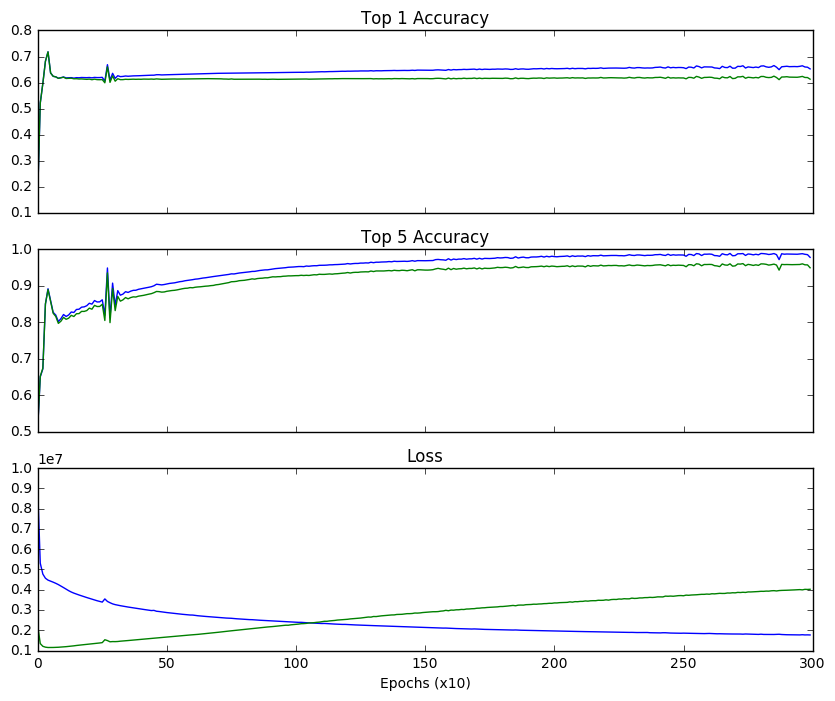

In [ ]:
#Plot accuracies and cost summary
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,8))

ax1.plot(accuracy_summary)
ax1.plot(test_accuracy_summary)
ax1.set_title('Top 1 Accuracy')

ax2.plot(accuracy_top5_summary)
ax2.plot(test_accuracy_top5_summary)
ax2.set_title('Top 5 Accuracy')

ax3.plot(loss_summary)
ax3.plot(test_loss_summary)
ax3.set_title('Loss')

plt.xlabel('Epochs (x10)')
plt.show()

In [ ]:
# Find the probabilities for each prediction
test_final = df_test.as_matrix()
final_probabilities = session.run(predictions, feed_dict={features: test_final,
                                                          pkeep: 1})

In [ ]:
# Explore some of the predictions
final_probabilities[0]

array([  7.34245255e-21,   5.02517741e-30,   1.42874395e-25,
         2.40796284e-15,   4.88082264e-07,   2.60900578e-07,
         1.31230571e-09,   9.99996901e-01,   3.10756943e-27,
         3.81869185e-14,   1.90081550e-06,   4.43023225e-07], dtype=float32)

In [ ]:
# Encode the labels for the countries
le = LabelEncoder()
fit_labels = le.fit_transform(train.country_destination) 

# Get the ids for the test data
test_getIDs = pd.read_csv("test_users.csv")
testIDs = test_getIDs['id']

ids = []  #list of ids
countries = []  #list of countries
for i in range(len(testIDs)):
    # Select the 5 countries with highest probabilities
    idx = testIDs[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(final_probabilities[i])[::-1])[:5].tolist()
    if i % 10000 == 0:
        print ("Percent complete: {}%".format(round(i / len(test),4)*100))

#Generate submission
submission = pd.DataFrame(np.column_stack((ids, countries)), columns=['id', 'country'])
submission.to_csv('submission.csv',index=False)

Percent complete: 0.0%
Percent complete: 16.1%
Percent complete: 32.21%
Percent complete: 48.309999999999995%
Percent complete: 64.42%
Percent complete: 80.52%
Percent complete: 96.61999999999999%


In [ ]:
# Check some of the submissions
submission.head(25)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,FR
3,5uwns89zht,other
4,5uwns89zht,GB
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,IT
8,jtl0dijy2j,other
9,jtl0dijy2j,FR


In [ ]:
# Compare the submission's distribution to the training data's distribution.
# Given that the data was randomly split, 
# a more equal distribution should lead to better scores in the Kaggle competition.
submission.country.value_counts()

US       62096
NDF      62074
FR       61792
other    61527
IT       45328
GB       15275
ES        1363
NL         679
AU         280
DE          60
CA           3
PT           3
Name: country, dtype: int64

In [ ]:
train.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

## Summary

Based on Kaggle's evaluation method (https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings#evaluation), the neural network scores just under 0.86 when all of the training data is used. The winning submission scored 0.88697 and the sample submission scored 0.68411. Looking at the leaderboard and some kernels, the most common algorithm for the better scores was XGBoost. Given that the purpose of this analyis was to further my knowledge of TensorFlow (in addition to the other aspects of machine learning - i.e. feature engineering, cleaning data, etc.), I do not feel the need to use XGBoost to try to make a better prediction. I am rather pleased with this model on a whole, given its ability to accurately predict which country a user will make his/her first trip in. The 'lazy' prediction method would be to use the top and top 5 most common countries for the predictions. This would equal an accuracy score of 58.35% for the top predictions and 95.98% for the top 5 predictions. For the testing data, my top predictions scored a higher accuracy of 62.37%, as well as for the top 5 predictions, at 95.99%. My predictions are also more useful since they make use of all twelve countries, instead of just the five most common.